In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [26]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


In [27]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [28]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [29]:
df[df['txt_content'].str.len() == 7]

,jpg_file,txt_content
6342,006343.jpg,Y4JS1VW
6741,006742.jpg,3TB9QOO
7180,007181.jpg,AMSML13


In [30]:
df['txt_content'].str.len().value_counts()

txt_content
6    7997
7       3
Name: count, dtype: int64

In [31]:
vocab = np.unique(list(df['txt_content'].sum()))
vocab = list(vocab)
vocab.append("*")
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '*'],
      dtype='<U1')

In [32]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (50, 180)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    num_parts = 7

    # Create a blank white image
    image = np.ones((*size, 1), dtype=np.uint8) * 255  # White background

    # Calculate positions for each part
    part_width = size[1] / num_parts
    vertical_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    vertical_positions = vertical_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_y = int((size[0] + cv2.getTextSize(text, font, font_scale, font_thickness)[0][1]) / 2)

    # Draw each letter at the calculated position
    for char, x in zip(text, vertical_positions):
        char_size, _ = cv2.getTextSize(char, font, font_scale, font_thickness)
        char_x = x - char_size[0] // 2  # Center the character horizontally within its part
        cv2.putText(image, char, (char_x, text_y), font, font_scale, (0,), font_thickness, lineType=cv2.LINE_AA)
    return image

In [33]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [34]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  Y = np.array([generate_clean_captcha(x) for x in df["txt_content"]])
  X = X.astype('float32') / 255.
  Y = Y.astype('float32') / 255.

  
  return X,Y,df['txt_content']

X_train, Y_train,labels_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val, Y_val,labels_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

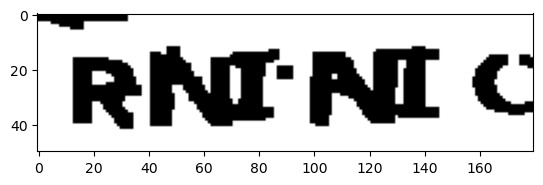

In [35]:
plt.imshow(X_train[0], cmap='gray')

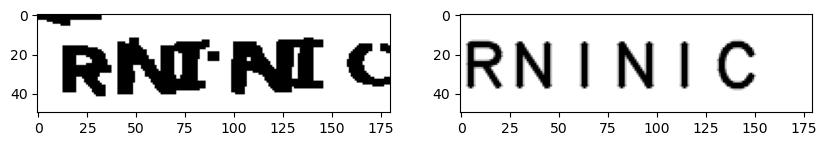

In [36]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [37]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [38]:
autoencoder = tf.keras.models.load_model('model_BCE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})

In [39]:
Y_train_pred_ae = autoencoder.predict(X_train)
Y_val_pred_ae = autoencoder.predict(X_val)

32/32 [==============================] - 1s 22ms/step


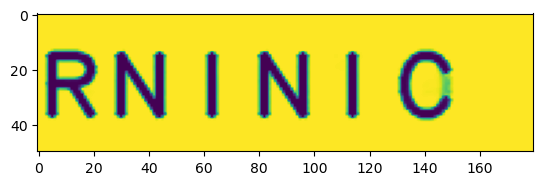

In [40]:
plt.imshow(Y_train_pred_ae[0])

In [41]:
bins = np.arange(0,180,180//7)

In [42]:
from sklearn.preprocessing import OneHotEncoder

def get_x_y_classification(X_pred, labels):
    # Adjust labels if their length is not equal to 7
    labels = labels.apply(lambda x: x + '*' if len(x) != 7 else x)

    # Define bins
    num_parts = 7
    img_width = 180
    bins = np.arange(0,180,180//7)

    # Initialize lists to hold the split images and one-hot encoded labels
    x = []
    y = []

    # One-hot encoder for labels
    encoder = OneHotEncoder()

    # Fit the encoder on the labels (unique characters)
    encoder.fit(np.array(list(vocab)).reshape(-1, 1))

    # Process each image and corresponding label
    for img, label in zip(X_pred, labels):
        # Split the image into 7 parts
        for i in range(num_parts):
            start, end = bins[i], bins[i + 1]
            part_img = img[:, start:end,:]
            x.append(part_img)

            char = label[i]
            one_hot = encoder.transform([[char]])[0]
            y.append(one_hot.toarray())

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)
    y = np.squeeze(y, axis=1)
    return x, y

X_train_class,Y_train_class = get_x_y_classification(Y_train_pred_ae,labels_train)
X_val_class,Y_val_class = get_x_y_classification(Y_val_pred_ae,labels_val)

In [43]:
del X_train 
del Y_train

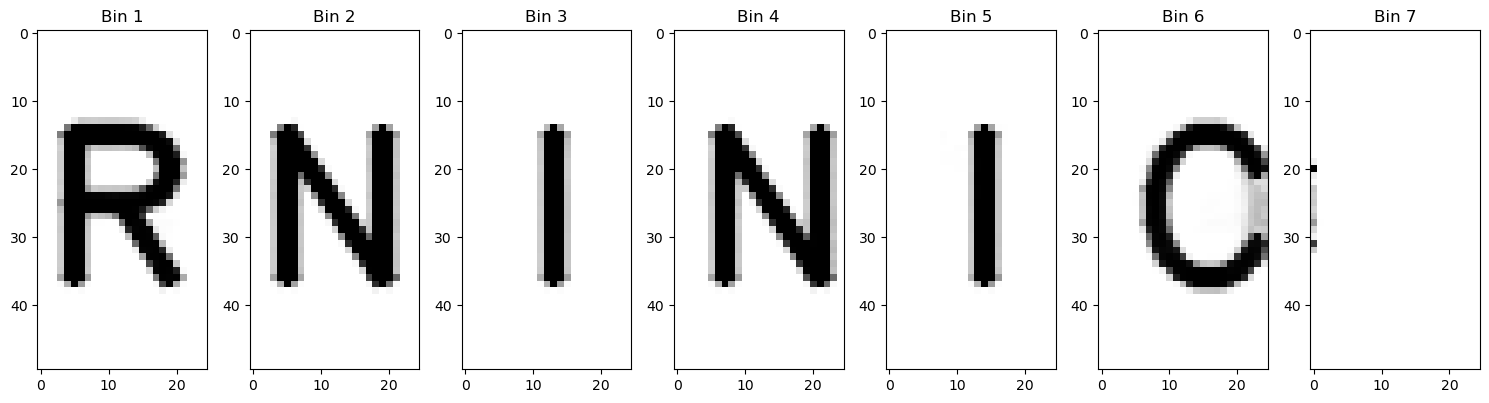

In [44]:
# Create subplots
num_bins = 7
fig, axes = plt.subplots(1, num_bins, figsize=(15, 5))

# Plot each bin separately
for i in range(num_bins):
    bin_slice = X_train_class[i]
    axes[i].imshow(bin_slice, cmap='gray')
    axes[i].set_title(f'Bin {i+1}')
plt.tight_layout()
plt.show()

In [45]:
def conv_bn_relu(filters, kernel_size, strides=(1, 1), padding='same'):
    def layer(x):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x
    return layer

def crop(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return x2_cropped

In [46]:
def classifier(input_img, num_blocks=1, num_downsample=3,n_out = 38):
    x = input_img

    for _ in range(2):
        x = conv_bn_relu(32, (3, 3))(x)

    # Contracting path
    for _ in range(num_downsample):
        for _ in range(num_blocks):
            x = conv_bn_relu(32, (3, 3))(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    for _ in range(num_blocks):
        x = conv_bn_relu(32, (3, 3))(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(n_out, activation='softmax')(x)

    return tf.keras.Model(inputs=input_img, outputs=output)


input_shape = X_train_class.shape[1:]  # Example input shape
input_img = Input(shape=input_shape)
model = classifier(input_img, num_blocks=1, num_downsample=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 25, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 25, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 50, 25, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 50, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 50, 25, 32)        128       
 chNormalization)                                            

In [47]:
checkpoint = ModelCheckpoint(
    'classifier_aug_best.tf',
    monitor='val_accuracy',  # Use 'val_loss' as an approximation of RMSE if the metric isn't directly available
    save_best_only=True,
    mode='max',
    verbose=1
)

In [48]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train_class)
batch_size = 64
augmented_data_generator = datagen.flow(X_train_class, Y_train_class, batch_size=batch_size)

In [49]:
history = model.fit(augmented_data_generator,
                steps_per_epoch=len(X_train_class) // batch_size,
                epochs=50,
                batch_size=batch_size,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(X_val_class, Y_val_class))

Epoch 1/50


2024-07-20 07:57:05.934087: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x729f0c05ac00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-20 07:57:05.934117: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-07-20 07:57:06.019208: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-20 07:57:06.424002: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


874/875 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.8980
Epoch 1: val_accuracy improved from -inf to 0.94986, saving model to classifier_aug_best.tf
INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


875/875 [==============================] - 24s 20ms/step - loss: 0.4309 - accuracy: 0.8981 - val_loss: 0.2643 - val_accuracy: 0.9499
Epoch 2/50
874/875 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9794
Epoch 2: val_accuracy improved from 0.94986 to 0.97300, saving model to classifier_aug_best.tf
INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


875/875 [==============================] - 21s 24ms/step - loss: 0.0854 - accuracy: 0.9793 - val_loss: 0.2138 - val_accuracy: 0.9730
Epoch 3/50
874/875 [============================>.] - ETA: 0s - loss: 0.0777 - accuracy: 0.9812
Epoch 3: val_accuracy did not improve from 0.97300
875/875 [==============================] - 15s 17ms/step - loss: 0.0777 - accuracy: 0.9812 - val_loss: 1.0190 - val_accuracy: 0.7561
Epoch 4/50
873/875 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9816
Epoch 4: val_accuracy did not improve from 0.97300
875/875 [==============================] - 15s 17ms/step - loss: 0.0729 - accuracy: 0.9817 - val_loss: 0.2672 - val_accuracy: 0.9344
Epoch 5/50
874/875 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9822
Epoch 5: val_accuracy did not improve from 0.97300
875/875 [==============================] - 16s 18ms/step - loss: 0.0713 - accuracy: 0.9822 - val_loss: 0.7418 - val_accuracy: 0.7576
Epoch 6/50
874/875 [=======

INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


875/875 [==============================] - 18s 21ms/step - loss: 0.0647 - accuracy: 0.9828 - val_loss: 0.1999 - val_accuracy: 0.9750
Epoch 10/50
874/875 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9833
Epoch 10: val_accuracy did not improve from 0.97500
875/875 [==============================] - 14s 16ms/step - loss: 0.0630 - accuracy: 0.9833 - val_loss: 1.0459 - val_accuracy: 0.7277
Epoch 11/50
872/875 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9836
Epoch 11: val_accuracy did not improve from 0.97500
875/875 [==============================] - 13s 15ms/step - loss: 0.0627 - accuracy: 0.9836 - val_loss: 0.6770 - val_accuracy: 0.7894
Epoch 12/50
873/875 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9835
Epoch 12: val_accuracy did not improve from 0.97500
875/875 [==============================] - 14s 16ms/step - loss: 0.0617 - accuracy: 0.9835 - val_loss: 1.1808 - val_accuracy: 0.7370
Epoch 13/50
873/875 [

INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


875/875 [==============================] - 17s 19ms/step - loss: 0.0496 - accuracy: 0.9851 - val_loss: 0.1854 - val_accuracy: 0.9756
Epoch 47/50
872/875 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9853
Epoch 47: val_accuracy did not improve from 0.97557
875/875 [==============================] - 14s 16ms/step - loss: 0.0499 - accuracy: 0.9853 - val_loss: 0.4238 - val_accuracy: 0.9473
Epoch 48/50
874/875 [============================>.] - ETA: 0s - loss: 0.0502 - accuracy: 0.9851
Epoch 48: val_accuracy did not improve from 0.97557
875/875 [==============================] - 14s 17ms/step - loss: 0.0502 - accuracy: 0.9851 - val_loss: 14.7481 - val_accuracy: 0.1646
Epoch 49/50
872/875 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9853
Epoch 49: val_accuracy did not improve from 0.97557
875/875 [==============================] - 14s 16ms/step - loss: 0.0500 - accuracy: 0.9853 - val_loss: 0.9586 - val_accuracy: 0.6691
Epoch 50/50
874/875 

In [50]:
model = tf.keras.models.load_model('classifier_aug_best.tf')

In [51]:
Y_train_pred = model.predict(X_train_class)
Y_val_pred = model.predict(X_val_class)

219/219 [==============================] - 1s 2ms/step


In [52]:
from sklearn.metrics import accuracy_score,classification_report

# Convert one-hot encoded labels to class indices for true labels
Y_val_class_indices = np.argmax(Y_val_class, axis=-1)

# Convert predictions to class indices
Y_val_pred_class_indices = np.argmax(Y_val_pred, axis=-1)

# Compute accuracy
accuracy = accuracy_score(Y_val_class_indices, Y_val_pred_class_indices)
print(f'Classification Accuracy: {accuracy}')

Classification Accuracy: 0.9755714285714285


In [53]:
report = classification_report(Y_val_class_indices, Y_val_pred_class_indices, output_dict=True, zero_division=0)
for label, metrics in report.items():
    if label.isdecimal():
        print(f'Class {vocab[int(label)]}:')
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1-score: {metrics['f1-score']:.2f}")
        print(f"  Support: {metrics['support']:.2f}\n")
    else:
        print(label,metrics)


Class 0:
  Precision: 1.00
  Recall: 1.00
  F1-score: 1.00
  Support: 999.00

Class 1:
  Precision: 0.96
  Recall: 0.93
  F1-score: 0.94
  Support: 184.00

Class 2:
  Precision: 0.99
  Recall: 0.94
  F1-score: 0.96
  Support: 198.00

Class 3:
  Precision: 0.99
  Recall: 0.98
  F1-score: 0.98
  Support: 162.00

Class 4:
  Precision: 0.98
  Recall: 0.98
  F1-score: 0.98
  Support: 138.00

Class 5:
  Precision: 0.99
  Recall: 0.98
  F1-score: 0.98
  Support: 153.00

Class 6:
  Precision: 0.96
  Recall: 0.97
  F1-score: 0.97
  Support: 161.00

Class 7:
  Precision: 0.98
  Recall: 0.99
  F1-score: 0.98
  Support: 175.00

Class 8:
  Precision: 0.99
  Recall: 0.98
  F1-score: 0.99
  Support: 189.00

Class 9:
  Precision: 0.97
  Recall: 0.97
  F1-score: 0.97
  Support: 147.00

Class ?:
  Precision: 0.97
  Recall: 1.00
  F1-score: 0.99
  Support: 150.00

Class A:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 0.00

Class B:
  Precision: 0.99
  Recall: 1.00
  F1-score: 0.99
  Suppo

In [54]:
import cv2
def draw_red_box_cv2(image, start_x, end_x, height=50):
    # Create a copy of the Simage
    image_copy = image.copy()
    
    # Define the rectangle color (BGR format for OpenCV)
    color = (0, 0, 255)  # Red color in BGR
    thickness = 2  # Thickness of the rectangle
    
    # Draw the rectangle
    top_left = (start_x, 0)
    bottom_right = (end_x, height)
    cv2.rectangle(image_copy, top_left, bottom_right, color, thickness)
    
    return image_copy

Number of misclassified instances: 171
Number of misclassified images: 155


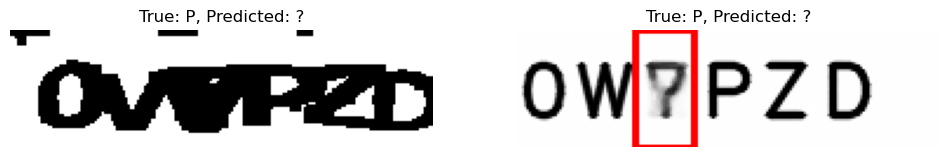

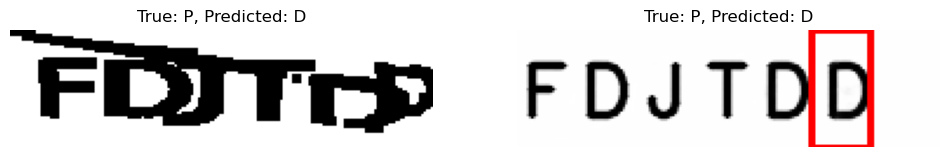

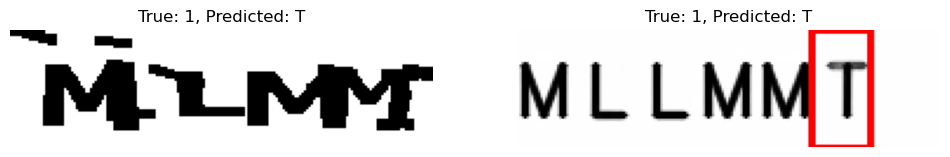

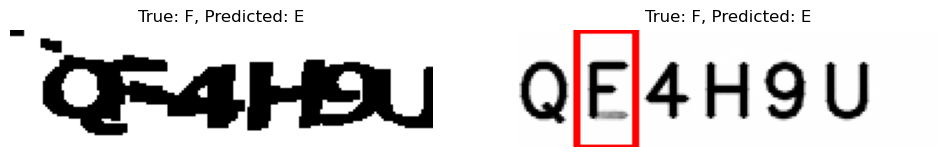

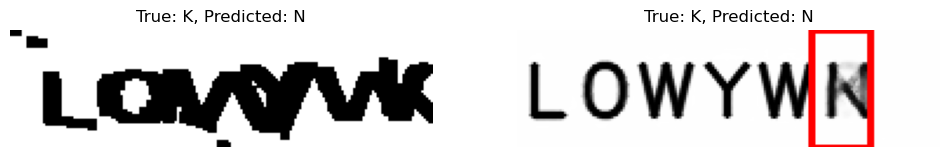

In [66]:
misclassified_indices = np.where(Y_val_class_indices != Y_val_pred_class_indices)[0]
print(f"Number of misclassified instances: {len(misclassified_indices)}")
print(f"Number of misclassified images: {len(np.unique(misclassified_indices//7))}")

# Print the first few misclassified instances
for i in misclassified_indices[10:15]:  # Adjust the number as needed
    start_x = bins[(i) % 7]
    end_x = bins[(i + 1) % 7]
    height = 50  # Fixed height of the red box

    original_image = X_val[i // 7]  # Original image
    predicted_image = Y_val_pred_ae[i // 7].squeeze()  # Remove the single channel dimension if it exists
    
    # Convert grayscale images to RGB
    original_image_rgb = cv2.cvtColor(original_image.squeeze(), cv2.COLOR_GRAY2RGB)
    predicted_image_rgb = cv2.cvtColor(predicted_image, cv2.COLOR_GRAY2RGB)
    
    # Draw the red box on the predicted image
    predicted_image_with_box = draw_red_box_cv2(predicted_image_rgb, start_x, end_x, height)

    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image_rgb, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {vocab[Y_val_class_indices[i]-1]}, Predicted: {vocab[Y_val_pred_class_indices[i]-1]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(predicted_image_with_box, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {vocab[Y_val_class_indices[i]-1]}, Predicted: {vocab[Y_val_pred_class_indices[i]-1]}")
    plt.axis('off')
    plt.show()

In [65]:
unique_miss = len(np.unique(misclassified_indices//7))
unique_miss /=X_val.shape[0]
1 - unique_miss

0.845

In [57]:
model.save('classifier_aug_20.keras')